In [1]:
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw
import io
from IPython.display import display
from IPython.display import clear_output
import ipywidgets
from base64 import b64decode , b64encode
import cv2

In [2]:
cv2.__file__

'/usr/lib/python3.6/dist-packages/cv2/python-3.6/cv2.cpython-36m-aarch64-linux-gnu.so'

In [3]:
cv2.__version__

'4.1.1'

In [43]:
import cv2
SRC_WIDTH ,SRC_HEIGHT  =640,480
#HEIGHT , WIDTH =480,640

def gstreamer_pipeline (capture_width=1280, capture_height=720 , display_width=640, 
     display_height=480, framerate=21, flip_method=2) :   
     return f"""nvarguscamerasrc ! 
     video/x-raw(memory:NVMM),width=(int){capture_width}, height=(int){capture_height}, format=(string)NV12, framerate=(fraction){framerate}/1 !
     nvvidconv  flip-method={flip_method} ! video/x-raw,width=(int){display_width}, height=(int){display_height},  format=BGRx ! 
     videoconvert ! video/x-raw,format=(string)BGR !
     appsink wait-on-eos=false max-buffers=2 drop=True
     """
    #
    
camera2 = cv2.VideoCapture(gstreamer_pipeline(display_width = SRC_WIDTH , display_height=SRC_HEIGHT))#, cv2.CAP_GSTREAMER)
#camera2.set(cv2.CAP_PROP_BUFFERSIZE, 1)
#retval, im = camera2.read()

In [79]:
def cam_read():
    #return camera2.read()#camera2.retrieve(camera2.grab())
    img = camera2.read()[1]
    #img = camera.value
#     img = Image.fromarray(img)
#     img = img.resize((WIDTH , HEIGHT))
#     img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return _ , img
    #return _,camera.value
    #return _, camera.read()

In [45]:
image_widget = ipywidgets.Image(format='jpg' , height=256 ,width=256)
display(image_widget)

Image(value=b'', format='jpg', height='256', width='256')

In [46]:
try:
    while True:
        image_widget.value =  cv2.imencode('.jpg',cam_read()[1])[1].tobytes()
except KeyboardInterrupt:
    print("Breaking")

Breaking


In [47]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           1979         991         126         108         861         829
Swap:          5085           0        5085


In [48]:
#camera2.release()

In [49]:
# import tensorrt
# import tensorflow as tf
import tflite_runtime.interpreter as tflite

In [50]:
import pathlib
import os

In [51]:
path = pathlib.Path("/home/unccv/drone_project")

In [52]:
#HEIGHT, WIDTH  = input_details[0]["shape"][1:3]
#HEIGHT , WIDTH =353,257

In [53]:
test_img = Image.open(os.path.join(path , "test_img.jpg"))

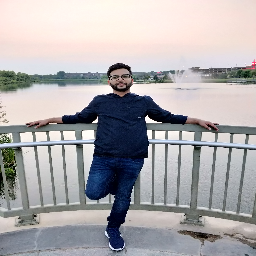

In [54]:
test_img.resize((256,256))

In [55]:
interpreter = tflite.Interpreter(model_path=os.path.join(path , "posenet_mobilenet_float_075_1_default_1.tflite"))

In [56]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           1979         979         139         108         861         842
Swap:          5085           0        5085


In [57]:
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [58]:
input_details

[{'name': 'sub_2',
  'index': 97,
  'shape': array([  1, 353, 257,   3], dtype=int32),
  'shape_signature': array([  1, 353, 257,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [59]:
output_details

[{'name': 'float_heatmaps',
  'index': 93,
  'shape': array([ 1, 23, 17, 17], dtype=int32),
  'shape_signature': array([ 1, 23, 17, 17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'float_short_offsets',
  'index': 96,
  'shape': array([ 1, 23, 17, 34], dtype=int32),
  'shape_signature': array([ 1, 23, 17, 34], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'float_mid_offsets',
  'index': 94,
  'shape': array([ 1, 23, 17, 64], dtype=int32),
  'shape_signature': array([ 1, 23, 17, 64], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': a

In [60]:
HEIGHT, WIDTH  = input_details[0]["shape"][1:3]

In [61]:
print(WIDTH);print(HEIGHT)

257
353


In [62]:
input_data = np.expand_dims(test_img.resize((WIDTH ,HEIGHT)), axis=0)
input_data.shape

(1, 353, 257, 3)

In [63]:
input_mean , input_std = 127.5  ,127.5
input_data = (np.float32(input_data) - input_mean) / input_std

In [64]:
interpreter.set_tensor(input_details[0]['index'], input_data)

In [65]:
interpreter.invoke()

In [66]:
output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)

In [67]:
results.shape

(23, 17, 17)

In [68]:
import enum
import numpy as np
import tflite_runtime.interpreter as tflite

class BodyPart(enum.IntEnum):
    __order__ = "NOSE LEFT_EYE RIGHT_EYE LEFT_EAR RIGHT_EAR LEFT_SHOULDER RIGHT_SHOULDER LEFT_ELBOW RIGHT_ELBOW LEFT_WRIST RIGHT_WRIST LEFT_HIP RIGHT_HIP LEFT_KNEE RIGHT_KNEE LEFT_ANKLE RIGHT_ANKLE"
    NOSE = 0
    LEFT_EYE = 1
    RIGHT_EYE= 2
    LEFT_EAR= 3
    RIGHT_EAR= 4
    LEFT_SHOULDER= 5
    RIGHT_SHOULDER = 6
    LEFT_ELBOW = 7
    RIGHT_ELBOW = 8
    LEFT_WRIST= 9
    RIGHT_WRIST= 10
    LEFT_HIP= 11
    RIGHT_HIP= 12
    LEFT_KNEE= 13
    RIGHT_KNEE = 14
    LEFT_ANKLE = 15
    RIGHT_ANKLE = 16

class Position:
    def __init__(self, x=0,y=0):
        self.x = x
        self.y = y

class KeyPoint:
    def __init__(self,bodypart = BodyPart.NOSE, position = Position() , score=0.0 ):
        self.bodyPart = bodypart
        self.position = position
        self.score = score

class Person:
    def __init__(self,keypoints = [] , score=0.0 , bodyScore=0.0):
        self.keyPoints = keypoints
        self.score = score
        self.bodyScore = bodyScore
    

class Posenet:

    def __init__(self,model_path="posenet_model.tflite"):
        self.lastInferenceTimeNanos = -1
        self.interpreter = None
        self.gpuDelegate = None
        self.model_path = model_path
        self.NUM_LITE_THREADS  = 4


    def getInterpreter(self):
        if self.interpreter is not None:
            return self.interpreter
        interpreter = tflite.Interpreter(model_path=self.model_path , num_threads = self.NUM_LITE_THREADS)
        interpreter.allocate_tensors()
        self.input_details = interpreter.get_input_details()
        self.output_details = interpreter.get_output_details()
        self.interpreter = interpreter
        return interpreter

    def close(self):
        self.interpreter.close()
        self.interpreter = None

    def sigmoid(self , x):
        return (1 / (1 + np.exp(-x)))

    def getKeyPointLocations(self, heatmaps):
        height , width , numKeyPoints = heatmaps.shape
        keypointPositions = [None]*numKeyPoints
        for keypoint in range(numKeyPoints):
            maxVal  = heatmaps[0][0][keypoint ]
            maxRow  , maxCol = 0,0
            for row in range(height):
                for col in range(width):
                     if (heatmaps[row][col][keypoint] > maxVal):
                         maxVal = heatmaps[row][col][keypoint]
                         maxRow = row
                         maxCol = col

            keypointPositions[keypoint] = (maxRow, maxCol)

        return keypointPositions

    def getConfidenceScores(self,heatmaps ,offsets,keypointPositions , height , width, HEIGHT , WIDTH):
        numKeyPoints = len(keypointPositions)
        xCoords = np.zeros(numKeyPoints)
        yCoords = np.zeros(numKeyPoints)
        confidenceScores  = np.zeros(numKeyPoints)

        for idx ,position in enumerate(keypointPositions):
            positionY  = keypointPositions[idx][0]
            positionX = keypointPositions[idx][1]
            yCoords[idx] = int( position[0] / float(height - 1) * HEIGHT + offsets[positionY][positionX][idx])
            xCoords[idx] = int( position[1] / float(width - 1) * WIDTH + offsets[positionY][positionX][idx + numKeyPoints])
            confidenceScores[idx] = self.sigmoid(heatmaps[positionY][positionX][idx])

        return xCoords , yCoords , confidenceScores

    def getPersonDetails(self , numKeyPoints , xCoords , yCoords,confidenceScores):
        person = Person()
        keypointList = []
        totalScore = 0
        bodyScore = 0
        for idx,it in enumerate(BodyPart):
            kp = KeyPoint()
            kp.bodyPart = it
            kp.position = Position(xCoords[idx],yCoords[idx]) 
            kp.score  = confidenceScores[idx]
            keypointList.append(kp)
            
            if idx > 4:
                bodyScore += confidenceScores[idx]
            totalScore += confidenceScores[idx]

        person.keyPoints = keypointList
        person.score = totalScore / numKeyPoints
        #print(bodyScore)
        person.bodyScore = bodyScore / (numKeyPoints - 5.0)
        return person

    def estimateSinglePose(self, image):
        self.getInterpreter()
        
        HEIGHT, WIDTH  = self.input_details[0]["shape"][1:3]
        input_data = np.expand_dims(image.resize((WIDTH ,HEIGHT)), axis=0)
        input_mean , input_std = 127.5  ,127.5
        input_data = (np.float32(input_data) - input_mean) / input_std

        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()

        heatmaps  = self.interpreter.get_tensor(self.output_details[0]['index'])
        heatmaps  = np.squeeze(heatmaps)

        offsets   = self.interpreter.get_tensor(self.output_details[1]['index'])
        offsets   = np.squeeze(offsets )

        height , width , numKeyPoints = heatmaps.shape

        keypointPositions = self.getKeyPointLocations(heatmaps )
        
        xCoords , yCoords , confidenceScores = (self.getConfidenceScores(heatmaps
                                                    , offsets
                                                    ,keypointPositions
                                                    , height
                                                    , width
                                                    , HEIGHT
                                                    , WIDTH))
        
        
        #print(xCoords , yCoords,confidenceScores)
        
        person = self.getPersonDetails( numKeyPoints , xCoords , yCoords,confidenceScores)
        return person
    
    def getDrawnImage(self, image):
        person = self.estimateSinglePose(image)
        out_img = np.array(image.resize((WIDTH ,HEIGHT)))
        for keypoint in person.keyPoints:
            out_img = cv2.circle( out_img , (int(keypoint.position.x) , int(keypoint.position.y)) , 10 , (42, 157, 143))
        return out_img

In [69]:
pnet = Posenet(os.path.join(path , "posenet_mobilenet_float_075_1_default_1.tflite"))

In [70]:
person_test = pnet.estimateSinglePose(test_img)

In [71]:
person_test.keyPoints[0].bodyPart

<BodyPart.NOSE: 0>

In [72]:
person_test.keyPoints[0].position.x

120.0

In [73]:
person_test.keyPoints[14].bodyPart

<BodyPart.RIGHT_KNEE: 14>

In [74]:
person_test.keyPoints[14].position.x

117.0

In [80]:
class StickMan:
    
    def lineBetweenPoints(self,image,pointA , pointB):
        if pointA.score > 0.5 and pointB.score > 0.5:
            return cv2.line(image 
                            , (int(pointA.position.x) , int(pointA.position.y)) 
                            , (int(pointB.position.x) , int(pointB.position.y))
                           , (42, 157, 143) , 2)
        return image
        
    def draw(self ,image , person):
        keypoints = person.keyPoints
        out_img = np.array(image.resize((WIDTH ,HEIGHT)))
        for keypoint in person.keyPoints:
            if keypoint.score > 0.5:
                out_img = cv2.circle( out_img , (int(keypoint.position.x) , int(keypoint.position.y)) , 5 , (251, 133, 0) , -1)
        
#         font = cv.FONT_HERSHEY_SIMPLEX
#         cv.putText(img,'OpenCV',(10,500), font, 4,(255,255,255),2,cv.LINE_AA)
        out_img = cv2.putText(out_img , str(person.score) , (20,20) 
                             , cv2.FONT_HERSHEY_SIMPLEX ,0.5, (0, 0, 0), 1, cv2.LINE_AA)
        
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.LEFT_WRIST)] , keypoints[int(BodyPart.LEFT_ELBOW)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.LEFT_ELBOW)] , keypoints[int(BodyPart.LEFT_SHOULDER)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.LEFT_SHOULDER)] , keypoints[int(BodyPart.RIGHT_SHOULDER)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.RIGHT_SHOULDER)] , keypoints[int(BodyPart.RIGHT_ELBOW)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.RIGHT_ELBOW)] , keypoints[int(BodyPart.RIGHT_WRIST)])
        
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.LEFT_HIP)] , keypoints[int(BodyPart.LEFT_KNEE)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.LEFT_KNEE)] , keypoints[int(BodyPart.LEFT_ANKLE)])
        
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.RIGHT_HIP)] , keypoints[int(BodyPart.RIGHT_KNEE)])
        out_img =  self.lineBetweenPoints(out_img , keypoints[int(BodyPart.RIGHT_KNEE)] , keypoints[int(BodyPart.RIGHT_ANKLE)])
        
        return out_img

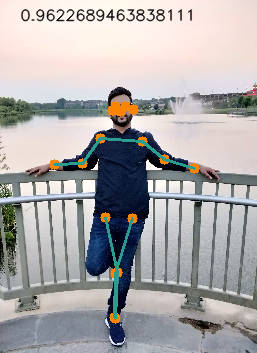

In [81]:
Image.fromarray(StickMan().draw(test_img  ,person_test))

In [82]:
image_widget = ipywidgets.Image(format='jpg' , height=256 ,width=256)
display(image_widget)

Image(value=b'', format='jpg', height='256', width='256')

In [85]:
stick_man = StickMan()
try:
    while True:
        img =cam_read()[1]
        pil_img = Image.fromarray(img)
        person = pnet.estimateSinglePose(pil_img)
        #if person.bodyScore > 0.5:
        img = stick_man.draw(pil_img,person)
        
        image_widget.value = cv2.imencode('.jpg',img)[1].tobytes()
        clear_output(wait=True)
        print(person.bodyScore)
except KeyboardInterrupt:
    print("Breaking")


0.0017199276631257145
Breaking


In [ ]:
input_data = np.expand_dims(test_img.resize((WIDTH ,HEIGHT)), axis=0)
input_data.shape

In [ ]:
input_mean , input_std = 127.5  ,127.5
input_data = (np.float32(input_data) - input_mean) / input_std

In [ ]:
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)

In [ ]:
results.shape

https://stackoverflow.com/questions/60032705/how-to-parse-the-heatmap-output-for-the-pose-estimation-tflite-model

https://github.com/google-coral/project-posenet

In [ ]:
def get_keypoints(heatmaps, offsets, output_stride=32):
        scores = sigmoid(heatmaps)
        num_keypoints = scores.shape[2]
        heatmap_positions = []
        offset_vectors = []
        confidences = []
        for ki in range(0, num_keypoints ):
            x,y = np.unravel_index(np.argmax(scores[:,:,ki]), scores[:,:,ki].shape)
            confidences.append(scores[x,y,ki])
            offset_vector = (offsets[y,x,ki], offsets[y,x,num_keypoints+ki])
            heatmap_positions.append((x,y))
            offset_vectors.append(offset_vector)
        image_positions = np.add(np.array(heatmap_positions) * output_stride, offset_vectors)
        keypoints = [KeyPoint(i, pos, confidences[i]) for i, pos in enumerate(image_positions)]
        return keypoints

In [ ]:
!free -m

First, let's load the JSON file which describes the human pose task.  This is in COCO format, it is the category descriptor pulled from the annotations file.  We modify the COCO category slightly, to add a neck keypoint.  We will use this task description JSON to create a topology tensor, which is an intermediate data structure that describes the part linkages, as well as which channels in the part affinity field each linkage corresponds to.

In [ ]:
import json
import trt_pose.coco

with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)

In [ ]:
!free -m

In [ ]:
import torch2trt
import torch
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
HEIGHT = 224
WIDTH = 224
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

In [ ]:
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

In [ ]:
!free -m

Next, let's define a function that will preprocess the image, which is originally in BGR8 / HWC format.

In [ ]:
import cv2
import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

Next, we'll define two callable classes that will be used to parse the objects from the neural network, as well as draw the parsed objects on an image.

In [ ]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

Assuming you're using NVIDIA Jetson, you can use the [jetcam](https://github.com/NVIDIA-AI-IOT/jetcam) package to create an easy to use camera that will produce images in BGR8/HWC format.

If you're not on Jetson, you may need to adapt the code below.

Next, we'll create a widget which will be used to display the camera feed with visualizations.

Finally, we'll define the main execution loop.  This will perform the following steps

1.  Preprocess the camera image
2.  Execute the neural network
3.  Parse the objects from the neural network output
4.  Draw the objects onto the camera image
5.  Convert the image to JPEG format and stream to the display widget

In [ ]:
def execute(image):
    #image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
#     image_w.value = bgr8_to_jpeg(image[:, ::-1, :])
#     #return bgr8_to_jpeg(image[:, ::-1, :])
#     return show_local_img(image[:, ::-1, :] , 256,256)
    return image

In [ ]:
import os
import numpy
import time
import PIL.Image
outpath = os.path.abspath(os.path.join("." , ".." , ".." , ".." , ".." , "drone_project" , "outdump"))
outpath

In [ ]:
image_widget = ipywidgets.Image(format='jpg' , height=256 ,width=256)
display(image_widget)

In [ ]:
!free -m

In [ ]:
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]
i = 0
try:
    t1 = time.time()
    while(True):
        
        # Capture frame-by-frame
        #_ , frame = camera2.read()
        #ret, frame = cam_read()
        camera2.grab()
        t2 = time.time()
        
        
            
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #exec_2(frame)
        if int(t2 - t1) > 2:
            ret, frame = cam_read()
            if not ret:
                print("Failed")
                break
            t1 = t2
            #frame = execute(frame)
            image_widget.value = cv2.imencode('.jpg', frame , encode_param)[1].tobytes()
            #cv2.imwrite(os.path.join(outpath , f"{i}.jpg") , frame)
            i += 1
        #image_widget.value = cv2.imencode('.jpg', frame , encode_param)[1].tobytes()
        #frame = execute(frame)
        #show_local_img(frame , 256, 256)
        clear_output(wait=True)
        
        print(f"waiting {t2 - t1}")
        
except KeyboardInterrupt:
    #cam.release()
    print("Stream stopped")

In [ ]:
!free -m

In [ ]:
exec_2({'new': camera.value})
camera.observe(exec_2, names='value')

In [ ]:
def execute(image):
    #image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
#     image_w.value = bgr8_to_jpeg(image[:, ::-1, :])
#     #return bgr8_to_jpeg(image[:, ::-1, :])
#     return show_local_img(image[:, ::-1, :] , 256,256)
    return draw_objects

If we call the cell below it will execute the function once on the current camera frame.

In [ ]:
image_w

In [ ]:
execute({'new': camera.value})

Call the cell below to attach the execution function to the camera's internal value.  This will cause the execute function to be called whenever a new camera frame is received.

In [ ]:
camera.observe(execute, names='value')

Call the cell below to unattach the camera frame callbacks.

In [ ]:
camera.unobserve_all()